bempp:HOST:INFO: Created grid with id 99019cc9-43e7-4748-b127-028ba34741a2. Elements: 228. Edges: 342. Vertices: 116
bempp:HOST:INFO: Created grid with id 8bcad8a0-9806-4101-8013-055632a3e4b6. Elements: 230. Edges: 345. Vertices: 117


bempp:HOST:INFO: Created grid with id 7481081c-2073-4190-aac7-ff38b8486656. Elements: 1368. Edges: 2052. Vertices: 686
bempp:HOST:INFO: Created grid with id 42138827-cc68-4de5-9457-e6490576dd1d. Elements: 1380. Edges: 2070. Vertices: 692
66 warnings generated.
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:417: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, [devices[i] for i in to_be_built_indices])
66 warnings generated.
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/usr/local/lib/python3.10/dist-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)
66

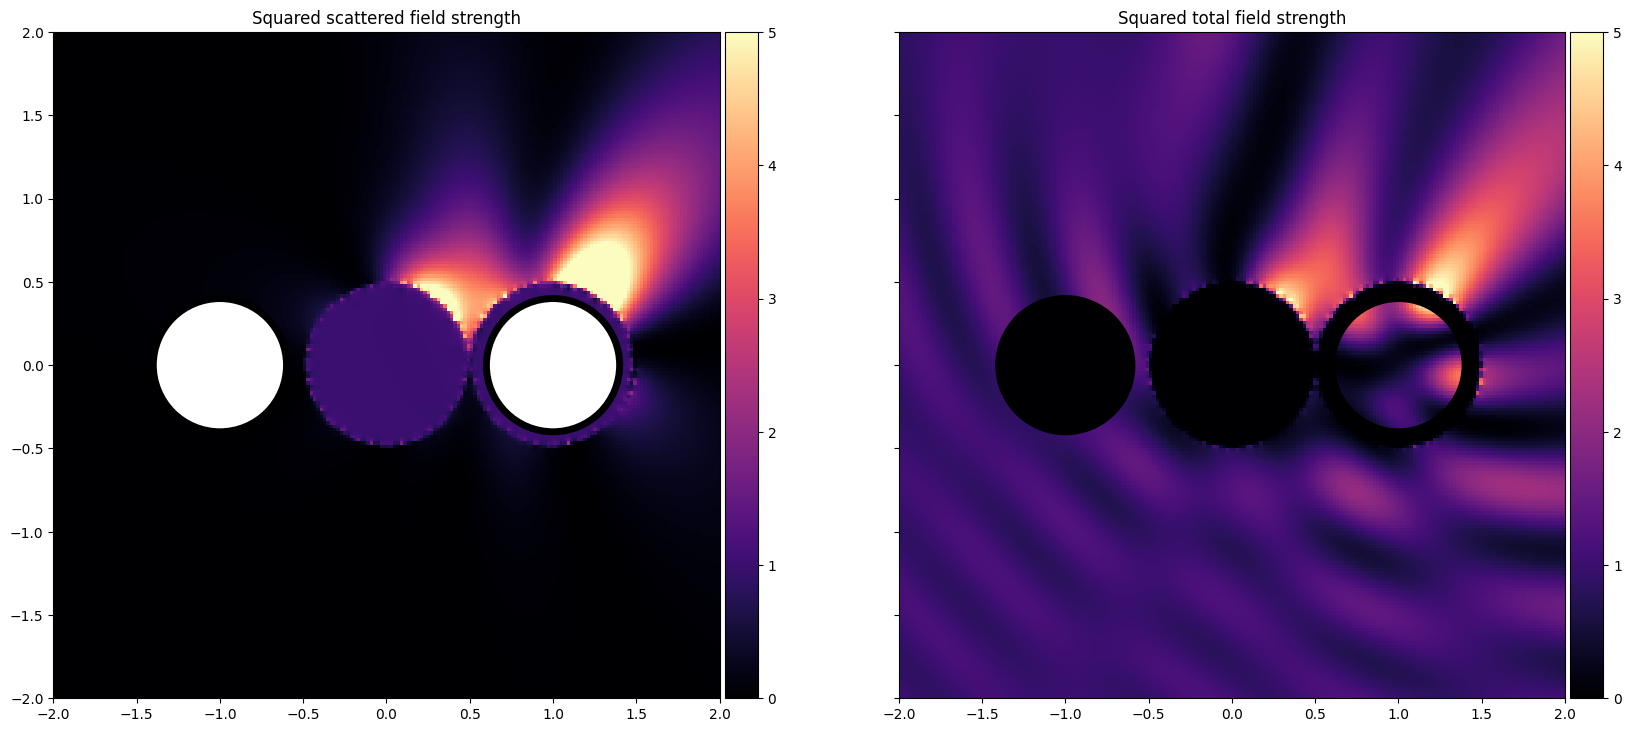

In [5]:
#Je reviens à quelque chose de beaucoup plus simple. On va prouver que l'on obtient le bon FF pour STF classique. 
#Travaillons en mode dense, facile.
# This first version is for the classical STF. 
# Now, try to get to the domain-based STF...

import bempp.api 
import numpy as np
import mtf

from bempp.api.operators.boundary.sparse import identity
from bempp.api.assembly.blocked_operator import BlockedOperator, GeneralizedBlockedOperator

from mtf.utils import bhmie
from mtf.config import config
from mtf.functions import define_bempp_functions
from mtf.assembly.operators import GeneralizedBlockedOperator

from matplotlib import pyplot as plt
from decimal import Decimal
from bempp.api import ZeroBoundaryOperator

bempp.api.enable_console_logging()
M = 3

sphere0 = bempp.api.shapes.sphere(r=.5, origin=(0., 0, 0), h=.2)
sphere1 = bempp.api.shapes.sphere(r=.5, origin=(1., 0, 0), h=.2)

frequency = 300E6 # 300Mhz

vacuum_permittivity = 8.854187817E-12
vacuum_permeability = 4 * np.pi * 1E-7

eps_r = 2.1
mu_r = 1.0

k_ext = 2 * np.pi * frequency * np.sqrt(vacuum_permittivity * vacuum_permeability)
k_int = k_ext * np.sqrt(eps_r * mu_r)

theta = np.pi / 4 # Incident wave travelling at a 45 degree angle
direction = np.array([np.cos(theta), np.sin(theta), 0])
polarization = np.array([0, 0, 1.0])

def plane_wave(point):
    return polarization * np.exp(1j * k_ext * np.dot(point, direction))

@bempp.api.complex_callable
def tangential_trace(point, n, domain_index, result):
    value = polarization * np.exp(1j * k_ext * np.dot(point, direction))
    result[:] =  np.cross(value, n)

@bempp.api.complex_callable
def neumann_trace(point, n, domain_index, result):
    value = np.cross(direction, polarization) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, direction))
    result[:] =  1./ (1j * k_ext) * np.cross(value, n)

from bempp.api.operators.boundary.maxwell import multitrace_operator
from bempp.api.operators.boundary.sparse import multitrace_identity

A0_int = multitrace_operator(
    sphere0, k_int, epsilon_r=eps_r, mu_r=mu_r, space_type='all_rwg')
A1_int = multitrace_operator(
    sphere1, k_int, epsilon_r=eps_r, mu_r=mu_r, space_type='all_rwg')
A0_ext = multitrace_operator(
    sphere0, k_ext, space_type='all_rwg')
A1_ext = multitrace_operator(
    sphere1, k_ext, space_type='all_rwg')
A01 = multitrace_operator(sphere1, k_ext, target=sphere0, space_type='all_rwg')
A10 = multitrace_operator(sphere0, k_ext, target=sphere1, space_type='all_rwg')


A = bempp.api.GeneralizedBlockedOperator([[A0_int + A0_ext, A01],
                                          [A10, A1_int + A1_ext]])


rhs = [bempp.api.GridFunction(space=A.range_spaces[0], dual_space=A.dual_to_range_spaces[0], fun=tangential_trace),
       bempp.api.GridFunction(space=A.range_spaces[1], dual_space=A.dual_to_range_spaces[1], fun=neumann_trace),
       bempp.api.GridFunction(space=A.range_spaces[2], dual_space=A.dual_to_range_spaces[2], fun=tangential_trace),
       bempp.api.GridFunction(space=A.range_spaces[3], dual_space=A.dual_to_range_spaces[3], fun=neumann_trace)]


bempp.api.enable_console_logging()
sol = bempp.api.linalg.lu(A, rhs)


# Number of points in the x-direction
nx = 200

# Number of points in the y-direction
ny = 200

# Generate the evaluation points with numpy
x, y, z = np.mgrid[-2:2:nx * 1j, -2:2:ny * 1j, 0:0:1j]
points = np.vstack((x.ravel(), y.ravel(), z.ravel()))


# Compute interior and exterior indices
all_indices = np.ones(points.shape[1], dtype='uint32')

interior_indices0 = np.sum((points - np.array([[-1, 0, 0]]).T)**2, axis=0) < .4**2
interior_indices1 = np.sum((points - np.array([[1, 0, 0]]).T)**2, axis=0) < .4**2
exterior_indices = ~interior_indices0 & ~interior_indices1

ext_points = points[:, exterior_indices]
int_points0 = points[:, interior_indices0]
int_points1 = points[:, interior_indices1]


mpot0_int = bempp.api.operators.potential.maxwell.magnetic_field(sol[0].space, int_points0, k_int)
epot0_int = bempp.api.operators.potential.maxwell.electric_field(sol[1].space, int_points0, k_int)
mpot0_ext = bempp.api.operators.potential.maxwell.magnetic_field(sol[0].space, ext_points, k_ext)
epot0_ext = bempp.api.operators.potential.maxwell.electric_field(sol[1].space, ext_points, k_ext)

mpot1_int = bempp.api.operators.potential.maxwell.magnetic_field(sol[2].space, int_points1, k_int)
epot1_int = bempp.api.operators.potential.maxwell.electric_field(sol[3].space, int_points1, k_int)
mpot1_ext = bempp.api.operators.potential.maxwell.magnetic_field(sol[2].space, ext_points, k_ext)
epot1_ext = bempp.api.operators.potential.maxwell.electric_field(sol[3].space, ext_points, k_ext)

exterior_values = -epot0_ext * sol[1] - mpot0_ext * sol[0]
exterior_values += -epot1_ext * sol[3] - mpot1_ext * sol[2]

interior_values0 = (np.sqrt(mu_r) / np.sqrt(eps_r) * epot0_int * sol[1] + mpot0_int * sol[0])
interior_values1 = (np.sqrt(mu_r) / np.sqrt(eps_r) * epot1_int * sol[3] + mpot1_int * sol[2])


from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle
plt.rcParams['figure.figsize'] = (20, 16) # Increase the figure size in the notebook

# First compute the scattered field
scattered_field = np.empty((3, points.shape[1]), dtype='complex128')
scattered_field[:, :] = np.nan
scattered_field[:, exterior_indices] = exterior_values

# Now compute the total field
total_field = np.empty((3, points.shape[1]), dtype='complex128')

for ext_ind in np.arange(points.shape[1])[exterior_indices]:
    total_field[:, ext_ind] = scattered_field[:, ext_ind] + plane_wave(points[:, ext_ind])
total_field[:, interior_indices0] = interior_values0
total_field[:, interior_indices1] = interior_values1
    
# Compute the squared field density
squared_scattered_field = np.sum(np.abs(scattered_field)**2, axis=0)
squared_total_field = np.sum(np.abs(total_field)**2, axis=0)

# Show the resulting images
scattered_image = squared_scattered_field.reshape(nx, ny).T
total_image = squared_total_field.reshape(nx, ny).T
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)

f0 = axes[0].imshow(scattered_image, origin='lower', cmap='magma',
                    extent=[-2, 2, -2, 2], vmin=0, vmax=5)
axes[0].add_patch(
    Circle((-1, 0), .4, facecolor='None', edgecolor='k', lw=5)
)
axes[0].add_patch(
    Circle((1, 0), .4, facecolor='None', edgecolor='k', lw=5)
)


axes[0].set_title("Squared scattered field strength")
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(f0, cax=cax)

f1 = axes[1].imshow(total_image, origin='lower', cmap='magma',
                    extent=[-2, 2, -2, 2], vmin=0, vmax=5)
axes[1].add_patch(
    Circle((-1, 0), .4, facecolor='None', edgecolor='k', lw=5)
)
axes[1].add_patch(
    Circle((1, 0), .4, facecolor='None', edgecolor='k', lw=5)
)


axes[1].set_title("Squared total field strength")
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(f1, cax=cax)

plt.show()



66 warnings generated.
66 warnings generated.


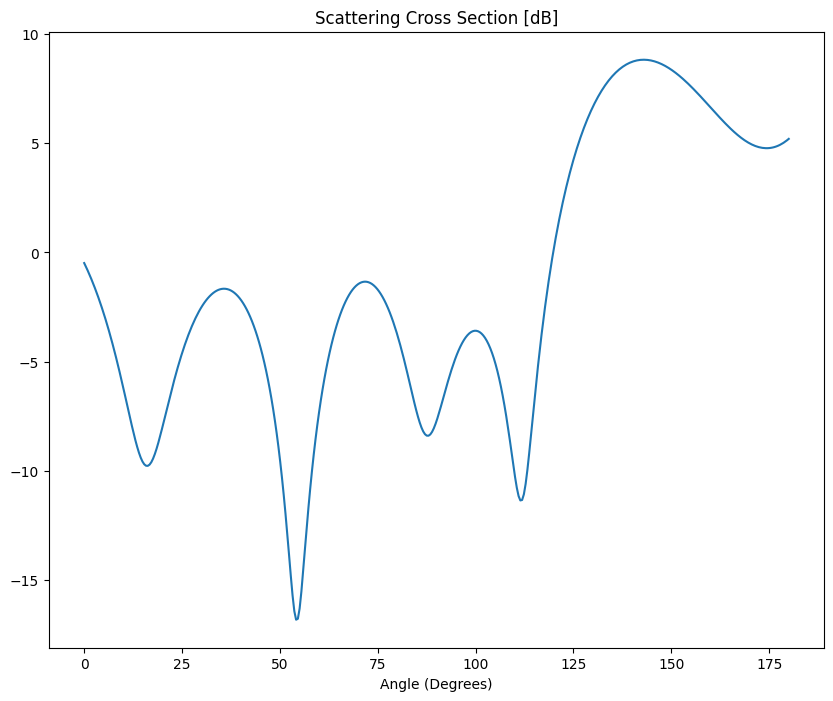

In [6]:
number_of_angles = 400
angles = np.pi * np.linspace(0, 1, number_of_angles)
unit_points = np.array([-np.cos(angles), -np.sin(angles), np.zeros(number_of_angles)])

far_field = np.zeros((3, number_of_angles), dtype='complex128')

for i in range(2):
    electric_far = bempp.api.operators.far_field.maxwell.electric_field(sol[2 * i + 1].space, unit_points, k_ext)
    magnetic_far = bempp.api.operators.far_field.maxwell.magnetic_field(sol[2 * i].space, unit_points, k_ext)    
    far_field += -electric_far * sol[2 * i + 1] - magnetic_far * sol[2 * i]
    
plt.rcParams['figure.figsize'] = (10, 8) # Resize the figure

cross_section = 10 * np.log10(4 * np.pi * np.sum(np.abs(far_field)**2, axis=0))
plt.plot(angles * 180 / np.pi, cross_section)
plt.title("Scattering Cross Section [dB]")
_ = plt.xlabel('Angle (Degrees)')